In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from scipy.optimize import minimize

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
# Set the hyperparameters for data creation
NUM_CLASSES = 2
NUM_FEATURES = 2
RANDOM_SEED = 17

# 1. Create multi-class data
X, y = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.8, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

In [68]:
X.shape, y.shape

((1000, 2), (1000,))

In [69]:

def get_scaled_feature(X: np.array):
    m = np.mean(X, axis=0)
    s = np.std(X, axis=0)
    
    return (X - m) / s

In [70]:
X = get_scaled_feature(X)

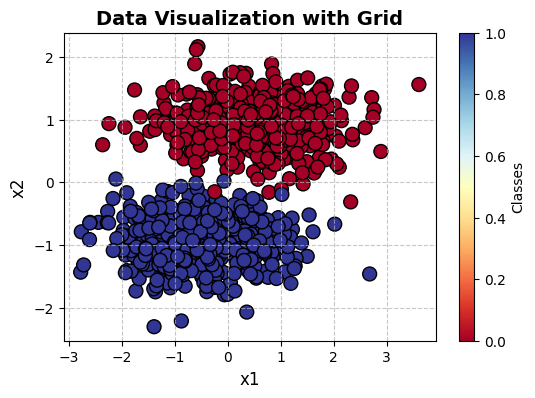

In [71]:
# let's plot the data
plt.figure(figsize=(6, 4))

# scatter plot with labels and grid
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolor='k', s=100)

# add title, labels, and grid
plt.title('Data Visualization with Grid', fontsize=14, fontweight='bold')
plt.xlabel('x1', fontsize=12)
plt.ylabel('x2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# display color bar to indicate classes
plt.colorbar(label='Classes')

# display the plot
plt.show()

In [72]:
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=42
)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((750, 2), (750,), (250, 2), (250,))

In [ ]:

class SVM:
    
    def __init__(self, C=1.0):
        self.C = C  # Regularization parameter
        self.w = None
        self.b = None
        self.alphas = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_alphas = None
    
    def fit(self, X, y):
        # Convert y from {0, 1} to {-1, 1} if needed
        y = np.where(y == 0, -1, y)
        
        # Store the training data
        self.X = X
        self.y = y
        m, n = X.shape
        
        # Compute the gram matrix
        K = X @ X.T
        
        # Objective function: Maximize f(alpha) = 1^T @ alpha - 0.5 * (alpha * y)^T @ K @ (alpha * y)
        def objective(alpha):
            alpha_y = alpha * y  # Element-wise product of alpha and y
            # Objective function to minimize (converted from maximization form)
            return -np.sum(alpha) + 0.5 * np.dot(alpha_y, K @ alpha_y)
        
        # Equality constraint: alpha^T @ y = 0
        constraints = [
            {'type': 'eq', 'fun': lambda alpha: np.dot(y, alpha)}
        ]

        # Bounds for each alpha: 0 <= alpha <= C
        bounds = [(0, self.C) for _ in range(m)]
        
        # Initial guess for alpha
        alpha0 = np.zeros(m)
        
        # Solve the problem
        result = minimize(objective, alpha0, bounds=bounds, constraints=constraints, method='SLSQP')
        self.alphas = result.x
        
        # Extract support vectors where 0 < alpha <= C
        epsilon = 1e-5
        support_vector_indices = np.where((self.alphas > epsilon) & (self.alphas < self.C))[0]
        margin_violator_indices = np.where(self.alphas == self.C)[0]
        
        # Store support vectors and margin violators
        self.support_vectors = X[support_vector_indices]
        self.support_vector_labels = y[support_vector_indices]
        self.support_alphas = self.alphas[support_vector_indices]
        self.margin_violators = X[margin_violator_indices]
        
        # Compute w
        self.w = self.X.T @ (self.alphas * self.y)
        
        # Compute b using any support vector
        self.b = np.mean(
            [self.support_vector_labels[i] - np.dot(self.w, self.support_vectors[i]) 
                for i in range(len(self.support_alphas))]
        )
        
    def predict(self, X):
        # Make predictions based on the sign of the decision function
        return np.sign(np.dot(X, self.w) + self.b)
    
    def decision_function(self, X):
        # Compute the decision function values
        return np.dot(X, self.w) + self.b
    
    def plot_decision_boundary(self):
        # Plot the original data points
        plt.scatter(self.X[:, 0], self.X[:, 1], c=self.y, cmap='bwr', alpha=0.7, s=50, label='Data Points')
        
        # Plot support vectors (0 < alpha < C)
        plt.scatter(self.support_vectors[:, 0], self.support_vectors[:, 1],
                    s=100, facecolors='none', edgecolors='k', label='Support Vectors')
        
        # Plot margin violators (alpha = C)
        plt.scatter(self.margin_violators[:, 0], self.margin_violators[:, 1],
                    s=100, facecolors='yellow', edgecolors='r', label='Margin Violators', alpha=0.6)
        
        # Create a grid to plot decision boundary and margins
        x_min, x_max = self.X[:, 0].min() - 1, self.X[:, 0].max() + 1
        y_min, y_max = self.X[:, 1].min() - 1, self.X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        grid = np.c_[xx.ravel(), yy.ravel()]
        
        # Compute decision function values for the grid
        Z = self.decision_function(grid)
        Z = Z.reshape(xx.shape)

        # Plot the decision boundary (where f(x) = 0)
        plt.contour(xx, yy, Z, levels=[0], colors='k', linestyles=['-'], linewidths=1.5)
        
        # Plot the margin boundaries (where f(x) = ±1)
        plt.contour(xx, yy, Z, levels=[-1, 1], colors='k', linestyles=['--'], linewidths=1)
        
        # Customize the plot
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.legend()
        plt.title('SVM Decision Boundary with Margin, Support Vectors, and Margin Violators')
        plt.show()

In [74]:
model = SVM(C=10.0)
model.fit(X_train, y_train)

In [75]:
model.w, model.b

(array([-1.37240169, -5.90900932]), 0.08324159491277694)

In [76]:
y_pred_train = model.predict(X_train)
y_pred_train = np.where(y_pred_train == -1, 0, 1)
y_pred_test = model.predict(X_test)
y_pred_test = np.where(y_pred_test == -1, 0, 1)

In [77]:
from sklearn.metrics import classification_report

In [78]:
# training set
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       369
           1       1.00      1.00      1.00       381

    accuracy                           1.00       750
   macro avg       1.00      1.00      1.00       750
weighted avg       1.00      1.00      1.00       750



In [79]:
# test set
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       131
           1       0.99      1.00      1.00       119

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



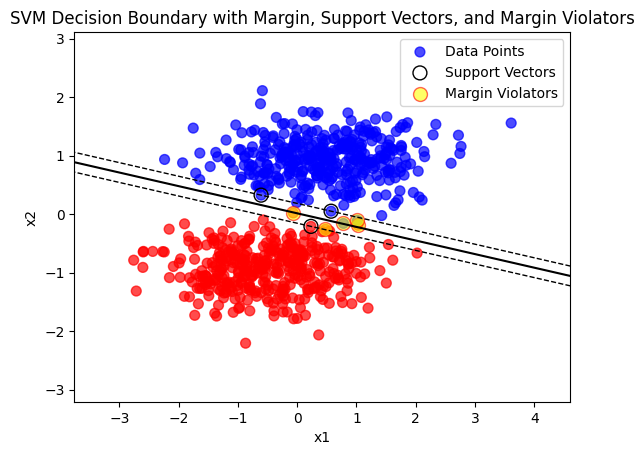

In [80]:
model.plot_decision_boundary()

In [81]:
model.support_vectors

array([[ 0.23135052, -0.20887033],
       [-0.61007157,  0.3250052 ],
       [ 0.57131774,  0.05062824]])

In [82]:
model.support_alphas

array([5.67446229, 8.37501922, 7.29944307])

In [83]:
model.margin_violators

array([[ 0.77991526, -0.1582737 ],
       [-0.06734796,  0.02017764],
       [ 1.02459109, -0.19113166],
       [ 1.01598175, -0.10698336],
       [ 0.47622875, -0.25753303]])

In [84]:
model.alphas

array([1.83382295e-14, 2.11057008e-14, 1.82763604e-13, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.84281881e-14, 4.65883757e-14,
       0.00000000e+00, 2.93677603e-14, 0.00000000e+00, 1.94278102e-14,
       2.46974793e-15, 1.13968223e-14, 0.00000000e+00, 6.60053197e-14,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.23984591e-14,
       7.18073674e-14, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.42105711e-14, 1.73297151e-14, 0.00000000e+00,
       0.00000000e+00, 4.53434951e-14, 4.06838261e-14, 1.56628096e-14,
       3.40804017e-14, 0.00000000e+00, 1.79623146e-14, 3.38295736e-14,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.54196629e-13, 2.89004993e-14, 0.00000000e+00, 6.04684299e-14,
       5.24789173e-14, 0.00000000e+00, 0.00000000e+00, 1.95761377e-13,
       2.05037884e-14, 1.93596446e-13, 9.15918829e-14, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.61119214e-14, 2.40300558e-14,
      